# Unsupervised Learning

In [1]:
import gensim
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyLDAvis
import os
import seaborn as sns; sns.set()  # for plot styling
import wordcloud

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.cluster import hierarchy

%matplotlib inline
plt.style.use('seaborn-white')

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Principal Component Analysis

**`USAarrests` data**

For each of the fifty states in the United States, the data set contains the number of arrests per 100, 000 residents for each of three crimes: `Assault` ,` Murder` ,and `Rape` . Other variable: `UrbanPop` (the percent of the population in each state living in urban areas).

In [2]:
df = pd.read_csv('USArrests.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
Murder      50 non-null float64
Assault     50 non-null int64
UrbanPop    50 non-null int64
Rape        50 non-null float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [3]:
df.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

### Pre-processing
PCA should be performed after standardizing each variable to have mean zero and standard deviation one.

In [4]:
X = pd.DataFrame(scale(df), index=df.index, columns=df.columns)

Text(0.5, 0, 'Murder')

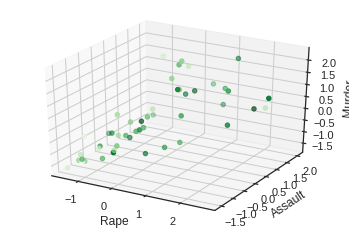

In [5]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(X['Rape'], X['Assault'], X['Murder'], c=X['UrbanPop'], cmap='Greens');
ax.set_xlabel('Rape')
ax.set_ylabel('Assault')
ax.set_zlabel('Murder')


### Fit PCA

In [6]:
# The loading vectors
pca_loadings = pd.DataFrame(PCA().fit(X).components_.T, index=df.columns, columns=['V1', 'V2', 'V3', 'V4'])
pca_loadings

,V1,V2,V3,V4
Murder,0.535899,0.418181,-0.341233,0.649228
Assault,0.583184,0.187986,-0.268148,-0.743407
UrbanPop,0.278191,-0.872806,-0.378016,0.133878
Rape,0.543432,-0.167319,0.817778,0.089024


In [7]:
# Fit the PCA model and transform X to get the principal components
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2', 'PC3', 'PC4'], index=X.index)
#df_plot

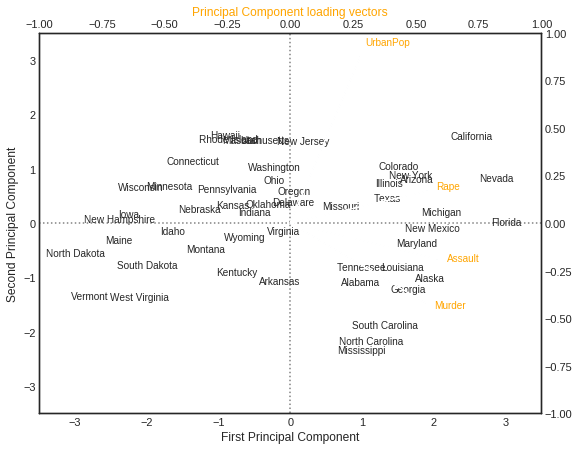

In [8]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

# Plot Principal Components 1 and 2
for i in df_plot.index:
    ax1.annotate(i, (df_plot.PC1.loc[i], -df_plot.PC2.loc[i]), ha='center')

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
    
# Plot Principal Component loading vectors, using a second y-axis.
ax2 = ax1.twinx().twiny() 

ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)
ax2.tick_params(axis='y', colors='orange')
ax2.set_xlabel('Principal Component loading vectors', color='orange')

# Plot labels for vectors. Variable 'a' is a small offset parameter to separate arrow tip and text.
a = 1.07  
for i in pca_loadings[['V1', 'V2']].index:
    ax2.annotate(i, (pca_loadings.V1.loc[i]*a, -pca_loadings.V2.loc[i]*a), color='orange')

# Plot vectors
ax2.arrow(0,0,pca_loadings.V1[0], -pca_loadings.V2[0])
ax2.arrow(0,0,pca_loadings.V1[1], -pca_loadings.V2[1])
ax2.arrow(0,0,pca_loadings.V1[2], -pca_loadings.V2[2])
ax2.arrow(0,0,pca_loadings.V1[3], -pca_loadings.V2[3]);

In [9]:
# Standard deviation of the four principal components
np.sqrt(pca.explained_variance_)

array([1.5908673 , 1.00496987, 0.6031915 , 0.4206774 ])

In [10]:
pca.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

In [11]:
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

### Choosing the number of components

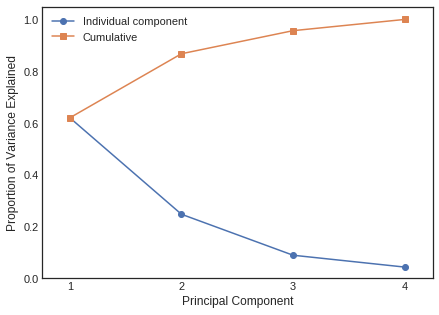

In [12]:
plt.figure(figsize=(7,5))

plt.plot([1,2,3,4], pca.explained_variance_ratio_, '-o', label='Individual component')
plt.plot([1,2,3,4], np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.legend(loc=2);

## Clustering Methods

- see https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
- overview of clustering methods: https://scikit-learn.org/stable/modules/clustering.html
- https://www.kaggle.com/dhanyajothimani/basic-visualization-and-clustering-in-python

Generate a two-dimensional dataset containing four distinct blobs:

Saving figure blobs_diagram


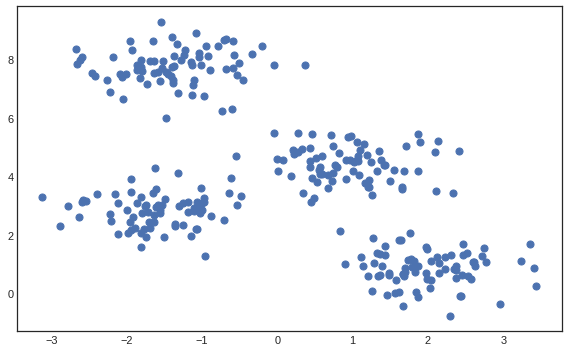

In [13]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], s=50);
save_fig("blobs_diagram")
plt.show()

### Means Clustering

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
y_kmeans # Each instance was assigned to one of the 4 clusters:

array([1, 0, 2, 0, 1, 1, 3, 2, 0, 0, 3, 0, 2, 0, 1, 2, 2, 1, 3, 3, 1, 1,
       2, 3, 3, 2, 1, 2, 3, 2, 0, 0, 2, 0, 0, 0, 0, 0, 3, 1, 2, 3, 2, 2,
       3, 3, 0, 3, 0, 1, 3, 1, 0, 1, 1, 3, 0, 3, 0, 1, 0, 2, 0, 3, 3, 3,
       0, 1, 0, 3, 2, 3, 0, 3, 3, 0, 3, 2, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2,
       0, 0, 2, 1, 0, 3, 3, 2, 1, 1, 2, 3, 0, 1, 0, 1, 2, 1, 1, 2, 0, 2,
       3, 3, 1, 0, 1, 2, 0, 1, 1, 2, 3, 1, 3, 1, 1, 1, 1, 3, 1, 3, 0, 3,
       3, 1, 0, 3, 3, 0, 2, 0, 0, 3, 2, 3, 2, 3, 0, 2, 0, 0, 0, 2, 0, 2,
       1, 3, 0, 3, 1, 2, 0, 2, 2, 1, 2, 3, 3, 2, 1, 2, 2, 0, 1, 2, 3, 0,
       1, 1, 2, 3, 1, 2, 3, 3, 2, 2, 2, 2, 1, 0, 2, 3, 2, 2, 3, 3, 3, 2,
       3, 0, 2, 3, 1, 3, 2, 0, 3, 0, 2, 0, 2, 3, 2, 2, 0, 3, 3, 1, 1, 2,
       0, 1, 1, 3, 1, 3, 2, 0, 0, 2, 2, 0, 2, 1, 3, 2, 1, 3, 0, 3, 1, 2,
       1, 0, 0, 0, 0, 3, 3, 0, 2, 3, 1, 2, 3, 3, 3, 1, 1, 0, 2, 2, 3, 1,
       0, 3, 2, 0, 2, 1, 1, 3, 3, 2, 1, 1, 1, 2, 0, 0, 1, 1, 2, 1, 1, 1,
       0, 3, 0, 2, 1, 1, 0, 0, 0, 1, 1, 2, 0, 3], d

In [15]:
kmeans.cluster_centers_ # The 4 centroïds estimated

array([[-1.37324398,  7.75368871],
       [ 1.98258281,  0.86771314],
       [ 0.94973532,  4.41906906],
       [-1.58438467,  2.83081263]])

we can predict the labels of new instances:

In [16]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([3, 1, 3, 3], dtype=int32)

Visualize the results:

Saving figure blobs_diagram_4clusters


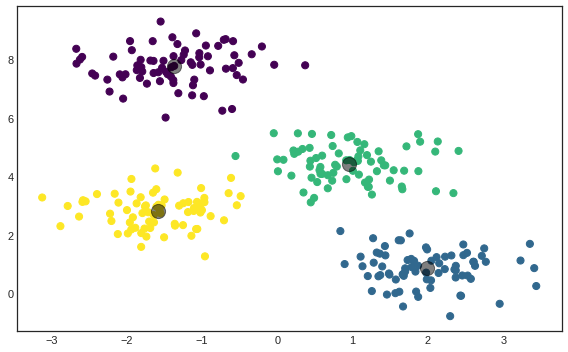

In [17]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
save_fig("blobs_diagram_4clusters")

Saving figure blobs_diagram_6clusters


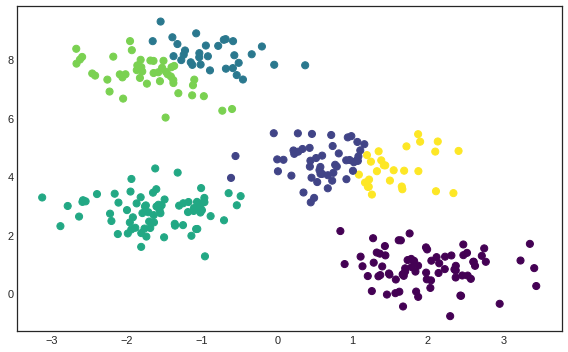

In [18]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');
save_fig("blobs_diagram_6clusters")

In [19]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_diagram


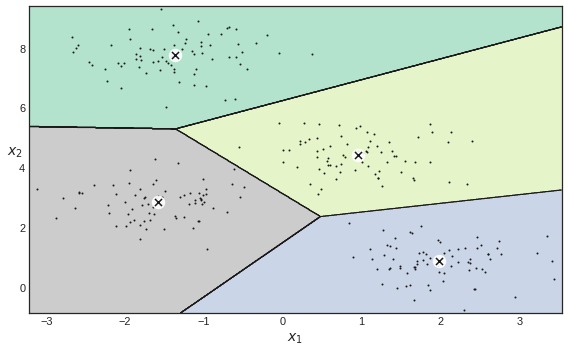

In [20]:
plt.figure(figsize=(8, 5))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_diagram")
plt.show()

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [21]:
kmeans_iter1 = KMeans(n_clusters=4, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=4, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=4, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', copy_x=True, init='random', max_iter=3, n_clusters=4,
       n_init=1, n_jobs=None, precompute_distances='auto', random_state=1,
       tol=0.0001, verbose=0)

Saving figure kmeans_algorithm_diagram


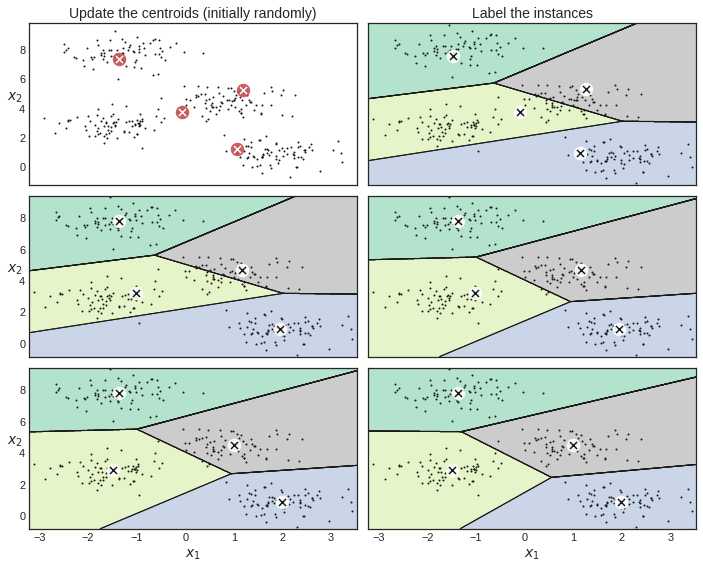

In [22]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_diagram")
plt.show()

### Finding the optimal number of clusers

Saving figure inertia_vs_k_diagram


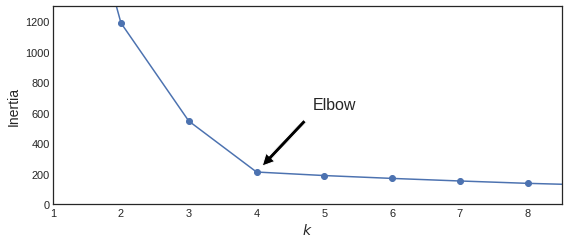

In [23]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_diagram")
plt.show()

In [25]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.6819938690643478

In [26]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_diagram


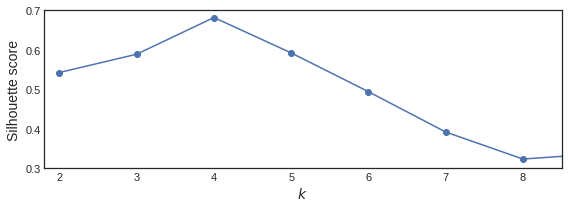

In [27]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.3, 0.7])
save_fig("silhouette_score_vs_k_diagram")
plt.show()

### Hierarchical Clustering
#### Fitting the model

In [28]:
from sklearn.cluster import AgglomerativeClustering
agglo = AgglomerativeClustering(n_clusters=5)
agglo.fit(X)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=5,
                        pooling_func='deprecated')

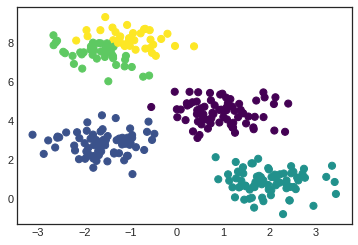

In [29]:
labels = agglo.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

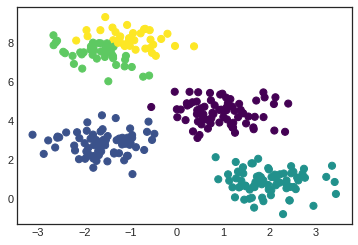

In [30]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)
labels = agglo.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### Dendrogram

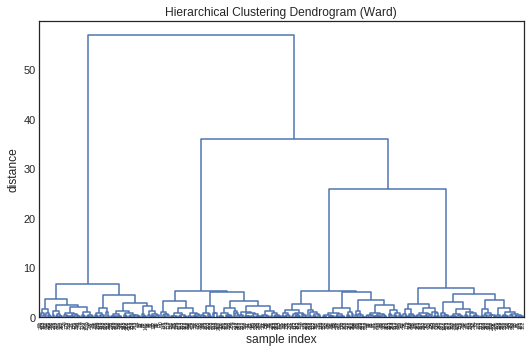

In [31]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(X, 'ward')
figure = plt.figure(figsize=(7.5, 5))
dendrogram(
    linkage_matrix,
    color_threshold=0,
)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.tight_layout()
plt.show()

## Topic models

We use as an example the **20 Newsgroups** ([[http://qwone.com/~jason/20Newsgroups/]]) dataset (from `sklearn`), a collection of about 20,000 newsgroup (message forum) documents. 
Cf. Week 4 on introduction to text analysis. 

In [32]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups() # object is a dictionary
data.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [33]:
W=data.data

In [36]:
import nltk
nltk.download('stopwords') 
nltk.download('punkt') 
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guillotm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/guillotm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Pre-processing

In [37]:
from gensim.utils import simple_preprocess

doc_clean = []
# iterate over rows
for i, text in enumerate(W):
    document = simple_preprocess(text) # get sentences/tokens
    document = [word for word in document if word not in stopwords] # remove stopwords
    doc_clean.append(document) # add to list
    if i > 100:
        break

In [38]:
# shuffle the documents
from random import shuffle
shuffle(doc_clean)

# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)

Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.

In [39]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

TF-IDF matrix

In [40]:
from gensim.models import TfidfModel
tfidf = TfidfModel(doc_term_matrix)  # fit model

In [41]:
vector = tfidf[doc_term_matrix[0]]  # apply model to the first corpus document
vector

[(0, 0.08683014006935355),
 (1, 0.10213755001036742),
 (2, 0.12513693865936062),
 (3, 0.07787587927069418),
 (4, 0.019075490961667278),
 (5, 0.10213755001036742),
 (6, 0.06659484480836919),
 (7, 0.10213755001036742),
 (8, 0.10213755001036742),
 (9, 0.09098680456554373),
 (10, 0.08683014006935355),
 (11, 0.20427510002073485),
 (12, 0.38937939635347096),
 (13, 0.07787587927069418),
 (14, 0.04726105938866642),
 (15, 0.05621532018732577),
 (16, 0.08683014006935355),
 (17, 0.07787587927069418),
 (18, 0.06256846932968031),
 (19, 0.025895586047264555),
 (20, 0.07787587927069418),
 (21, 0.1736602801387071),
 (22, 0.07787587927069418),
 (23, 0.11243064037465154),
 (24, 0.10213755001036742),
 (25, 0.08683014006935355),
 (26, 0.10213755001036742),
 (27, 0.11243064037465154),
 (28, 0.20427510002073485),
 (29, 0.07787587927069418),
 (30, 0.01664623950663865),
 (31, 0.10213755001036742),
 (32, 0.10213755001036742),
 (33, 0.04726105938866642),
 (34, 0.08683014006935355),
 (35, 0.1736602801387071),
 (

In [42]:
corpus_tfidf = tfidf[doc_term_matrix]   # apply model to whole corpus

### Topic modeling

Parameters of LDA

    num_topics
        specify how many topics you would like to extract from the documents

    alpha
        document-topic density
            the greater, the article will be assigned to more topics, vice versa

    eta
        topic-word density
            the greater, each topic will contain more words, vice versa


#### Using the DTM

In [43]:
# train LDA with 10 topics and print 
from gensim.models.ldamodel import LdaModel

lda = LdaModel(doc_term_matrix, num_topics=10, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=False)

[(0,
  [('edu', 0.008742735),
   ('com', 0.005391374),
   ('lines', 0.005387248),
   ('subject', 0.005352518),
   ('would', 0.0052913236),
   ('organization', 0.005227808),
   ('weapons', 0.00485524),
   ('oracle', 0.0034425415),
   ('like', 0.0033950654),
   ('engr', 0.0032624598)]),
 (1,
  [('edu', 0.008301184),
   ('armenian', 0.006237402),
   ('lines', 0.005131109),
   ('one', 0.004701572),
   ('people', 0.0044706105),
   ('subject', 0.0041421014),
   ('would', 0.0041198204),
   ('armenians', 0.0040397653),
   ('russian', 0.0038620722),
   ('jews', 0.003715302)]),
 (2,
  [('edu', 0.0056732697),
   ('lines', 0.0053996276),
   ('subject', 0.0053246394),
   ('organization', 0.0048670312),
   ('article', 0.0042298674),
   ('power', 0.0038203653),
   ('board', 0.003711021),
   ('also', 0.0035328814),
   ('one', 0.0034710586),
   ('option', 0.0034569448)]),
 (3,
  [('revolver', 0.005948512),
   ('semi', 0.005380426),
   ('organization', 0.0047851386),
   ('lines', 0.0046640243),
   ('sub

#### Using the TF-IDF

In [44]:
lda_idf = LdaModel(corpus_tfidf, num_topics=10, 
               id2word = dictionary, passes=3)
lda_idf.show_topics(formatted=False)

[(0,
  [('atari', 0.001026722),
   ('kaldis', 0.00093751797),
   ('font', 0.00092321594),
   ('rutgers', 0.00091179257),
   ('virginia', 0.000896016),
   ('plants', 0.00084392563),
   ('western', 0.00079853093),
   ('ford', 0.0007665351),
   ('atlanta', 0.0007665049),
   ('water', 0.0007396993)]),
 (1,
  [('starters', 0.0010225805),
   ('hijaak', 0.0008303325),
   ('lefthanded', 0.00076611893),
   ('moa', 0.00076236035),
   ('insurance', 0.0007542598),
   ('code', 0.0007459938),
   ('windows', 0.0007405361),
   ('moral', 0.0006825256),
   ('tmc', 0.0006605209),
   ('dlmqc', 0.00065694266)]),
 (2,
  [('tiff', 0.0013355914),
   ('captain', 0.0009051453),
   ('traded', 0.0008904936),
   ('cd', 0.0008733043),
   ('informix', 0.0007669553),
   ('toshiba', 0.0006952442),
   ('billd', 0.0006952432),
   ('begat', 0.000671444),
   ('daughters', 0.0006714413),
   ('leafs', 0.0005986675)]),
 (3,
  [('clock', 0.00089267676),
   ('revolver', 0.0007971685),
   ('car', 0.00079475006),
   ('purchased'

In [45]:
# to get the topic proportions for a document, use
# the corresponding row from the document-term matrix.
lda[doc_term_matrix[0]]

[(4, 0.9907192)]

### LDA Visualization
#### Wordcloud
The wordcloud package builds a visual representation of most common words. We apply it by topic here

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:349: DeprecationWarning: ranks_only is deprecated and will be removed as it had no effect. Look into relative_scaling.
  DeprecationWarning)


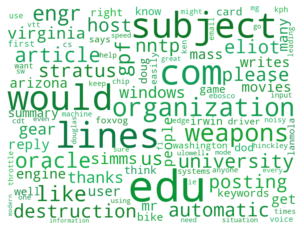

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:349: DeprecationWarning: ranks_only is deprecated and will be removed as it had no effect. Look into relative_scaling.
  DeprecationWarning)


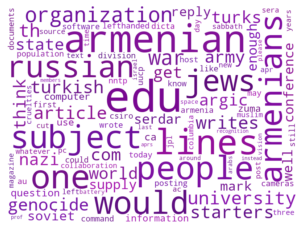

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:349: DeprecationWarning: ranks_only is deprecated and will be removed as it had no effect. Look into relative_scaling.
  DeprecationWarning)


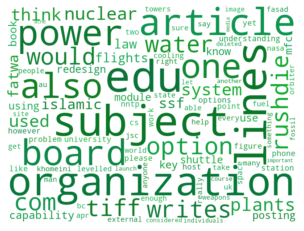

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:349: DeprecationWarning: ranks_only is deprecated and will be removed as it had no effect. Look into relative_scaling.
  DeprecationWarning)


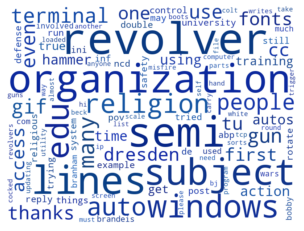

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:349: DeprecationWarning: ranks_only is deprecated and will be removed as it had no effect. Look into relative_scaling.
  DeprecationWarning)


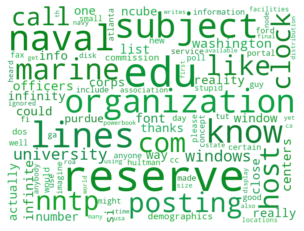

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:349: DeprecationWarning: ranks_only is deprecated and will be removed as it had no effect. Look into relative_scaling.
  DeprecationWarning)


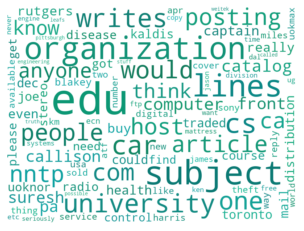

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:349: DeprecationWarning: ranks_only is deprecated and will be removed as it had no effect. Look into relative_scaling.
  DeprecationWarning)


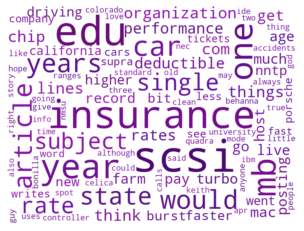

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:349: DeprecationWarning: ranks_only is deprecated and will be removed as it had no effect. Look into relative_scaling.
  DeprecationWarning)


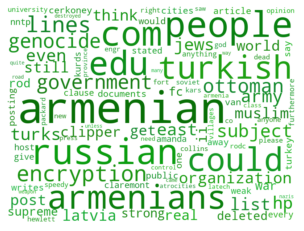

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:349: DeprecationWarning: ranks_only is deprecated and will be removed as it had no effect. Look into relative_scaling.
  DeprecationWarning)


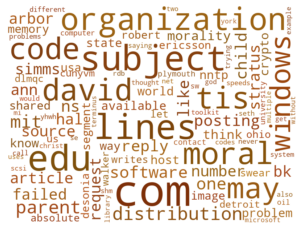

/usr/local/lib/python3.6/dist-packages/wordcloud/wordcloud.py:349: DeprecationWarning: ranks_only is deprecated and will be removed as it had no effect. Look into relative_scaling.
  DeprecationWarning)


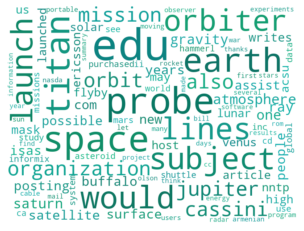

In [46]:
###
# LDA Word Clouds
###

from numpy.random import randint
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# make directory if not exists
from os import mkdir
try:
    mkdir('lda')
except:
    pass

# make word clouds for the topics
for i,weights in lda.show_topics(num_topics=-1,
                                 num_words=100,
                                 formatted=False):
    
    #logweights = [w[0], np.log(w[1]) for w in weights]
    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.clf()
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis("off")
    plt.show()

#### PyLDavis visualization

In [49]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [50]:
data = pyLDAvis.gensim.prepare(lda, doc_term_matrix, dictionary)
data

/usr/local/lib/python3.6/dist-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.133690 -0.037327       1        1  21.383921
2      0.065792 -0.106644       2        1  13.623513
9     -0.034309  0.024661       3        1  10.972277
6      0.021620  0.114593       4        1   9.941735
5      0.032947  0.047313       5        1   9.271972
3      0.031201 -0.040367       6        1   8.160040
0      0.041508  0.001378       7        1   7.485401
8      0.043625 -0.011308       8        1   6.718001
7     -0.074568 -0.006045       9        1   6.294330
4      0.005872  0.013745      10        1   6.148811, topic_info=     Category       Freq       Term      Total  loglift  logprob
2075  Default  29.000000       scsi  29.000000  30.0000  30.0000
3775  Default  20.000000  insurance  20.000000  29.0000  29.0000
131   Default  36.000000   armenian  36.000000  28.0000  28.0000
3372  Default  11.000000    reserve  11.000000  27.0000  27.0000
1353  Default  16.000000         mb  16.000000  26.0000  26.0000
...       ...        ...        ...        ...      ...      ...
1180  Topic10   2.380321     really  17.900623   0.7713  -6.0761
63    Topic10   2.334009     thanks  15.974729   0.8655  -6.0958
275   Topic10   2.362584      could  23.959438   0.4723  -6.0836
989   Topic10   2.323583        way  17.838179   0.7507  -6.1003
672   Topic10   2.262353        one  62.116463  -0.5237  -6.1270

[639 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
3398      6  0.825761     abp
1308      1  0.190768  access
1308      2  0.286151  access
1308      6  0.286151  access
1308      7  0.095384  access
...     ...       ...     ...
1024      9  0.043772   years
1232      8  0.756674    yhwh
2264      8  0.505636  zazula
4412     10  0.506784     zod
1030      1  0.767552    zuma

[1260 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 10, 7, 6, 4, 1, 9, 8, 5])